In [31]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from IPython.display import display
%matplotlib inline

# Importing  and cleaning the data set

In [2]:
data_train_db = pd.read_csv('data_train_db.csv')
data_test_db = pd.read_csv('data_test_db.csv')

In [3]:
#It seems like there are some data points which have much higher standard deviation than most. Lets just remove those.
def clean_dataset(data):
    to_drop= []
    for k in range(data.shape[0]):
        if data[k,:].std()>12:
            to_drop.append(k)   
    return np.delete(data, to_drop, axis = 0)

data_train = data_train_db.values
columns=data_train_db.columns

data_train = clean_dataset(data_train)
df_train=pd.DataFrame(data_train,columns=columns)

# Looking for patterns in the data set

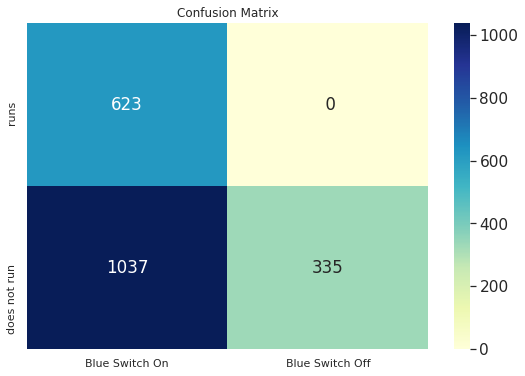

In [4]:
runs_switchon = np.count_nonzero((data_train[:,0]==1)*(data_train[:,1]==1))
runs_switchoff = np.count_nonzero((data_train[:,0]==1)*(data_train[:,1]==0))
runsnot_switchon = np.count_nonzero((data_train[:,0]==0)*(data_train[:,1]==1))
runsnot_switchoff = np.count_nonzero((data_train[:,0]==0)*(data_train[:,1]==0))
conf_matrix = [[runs_switchon, runs_switchoff], [runsnot_switchon, runsnot_switchoff]]

sn.set(color_codes=True)
plt.figure(1, figsize=(9, 6))

plt.title("Confusion Matrix")

sn.set(font_scale=1.4)
ax = sn.heatmap(conf_matrix, annot=True, cmap="YlGnBu",fmt='2')

ax.set_yticklabels(['runs', 'does not run'])
ax.set_xticklabels(['Blue Switch On', 'Blue Switch Off'])
plt.show()


Hence if the **Blue Switch On** is off=0 the machine does not run.


 
Next we look at variable witch are highly (positively or negatively) corrolated (pearson) with "Running" for easily spotted deppendencies:

In [5]:
#S is the list of variables sorted by how highly (positively or negatively) corrolated they are with "Running" 
s = np.argsort(np.abs(np.array(df_train.corr()['Running'])))[::-1]
S=columns[s]

#Since we already know how "Running" and "Blue Switch On" corrolate with "Running" we delete those
S = S.drop(["Running","Blue Switch On"])

Since some of the variables are binary scatterplots will only be informative if we add some sort of jitter:

In [6]:
df_train_jitter=df_train.copy()
#CB is a list of binary variables
CB=[c for c in columns if len(np.unique(df_train[c]))<20] 
CB=CB[2:]#We ignore the "Running" and "Blue Swich On"
for c in CB:
    df_train_jitter[c]+=np.random.uniform(-1/4,1/4,len(df_train_jitter))

Now we plot the plot the interaction of the variables most correlated with "Running"

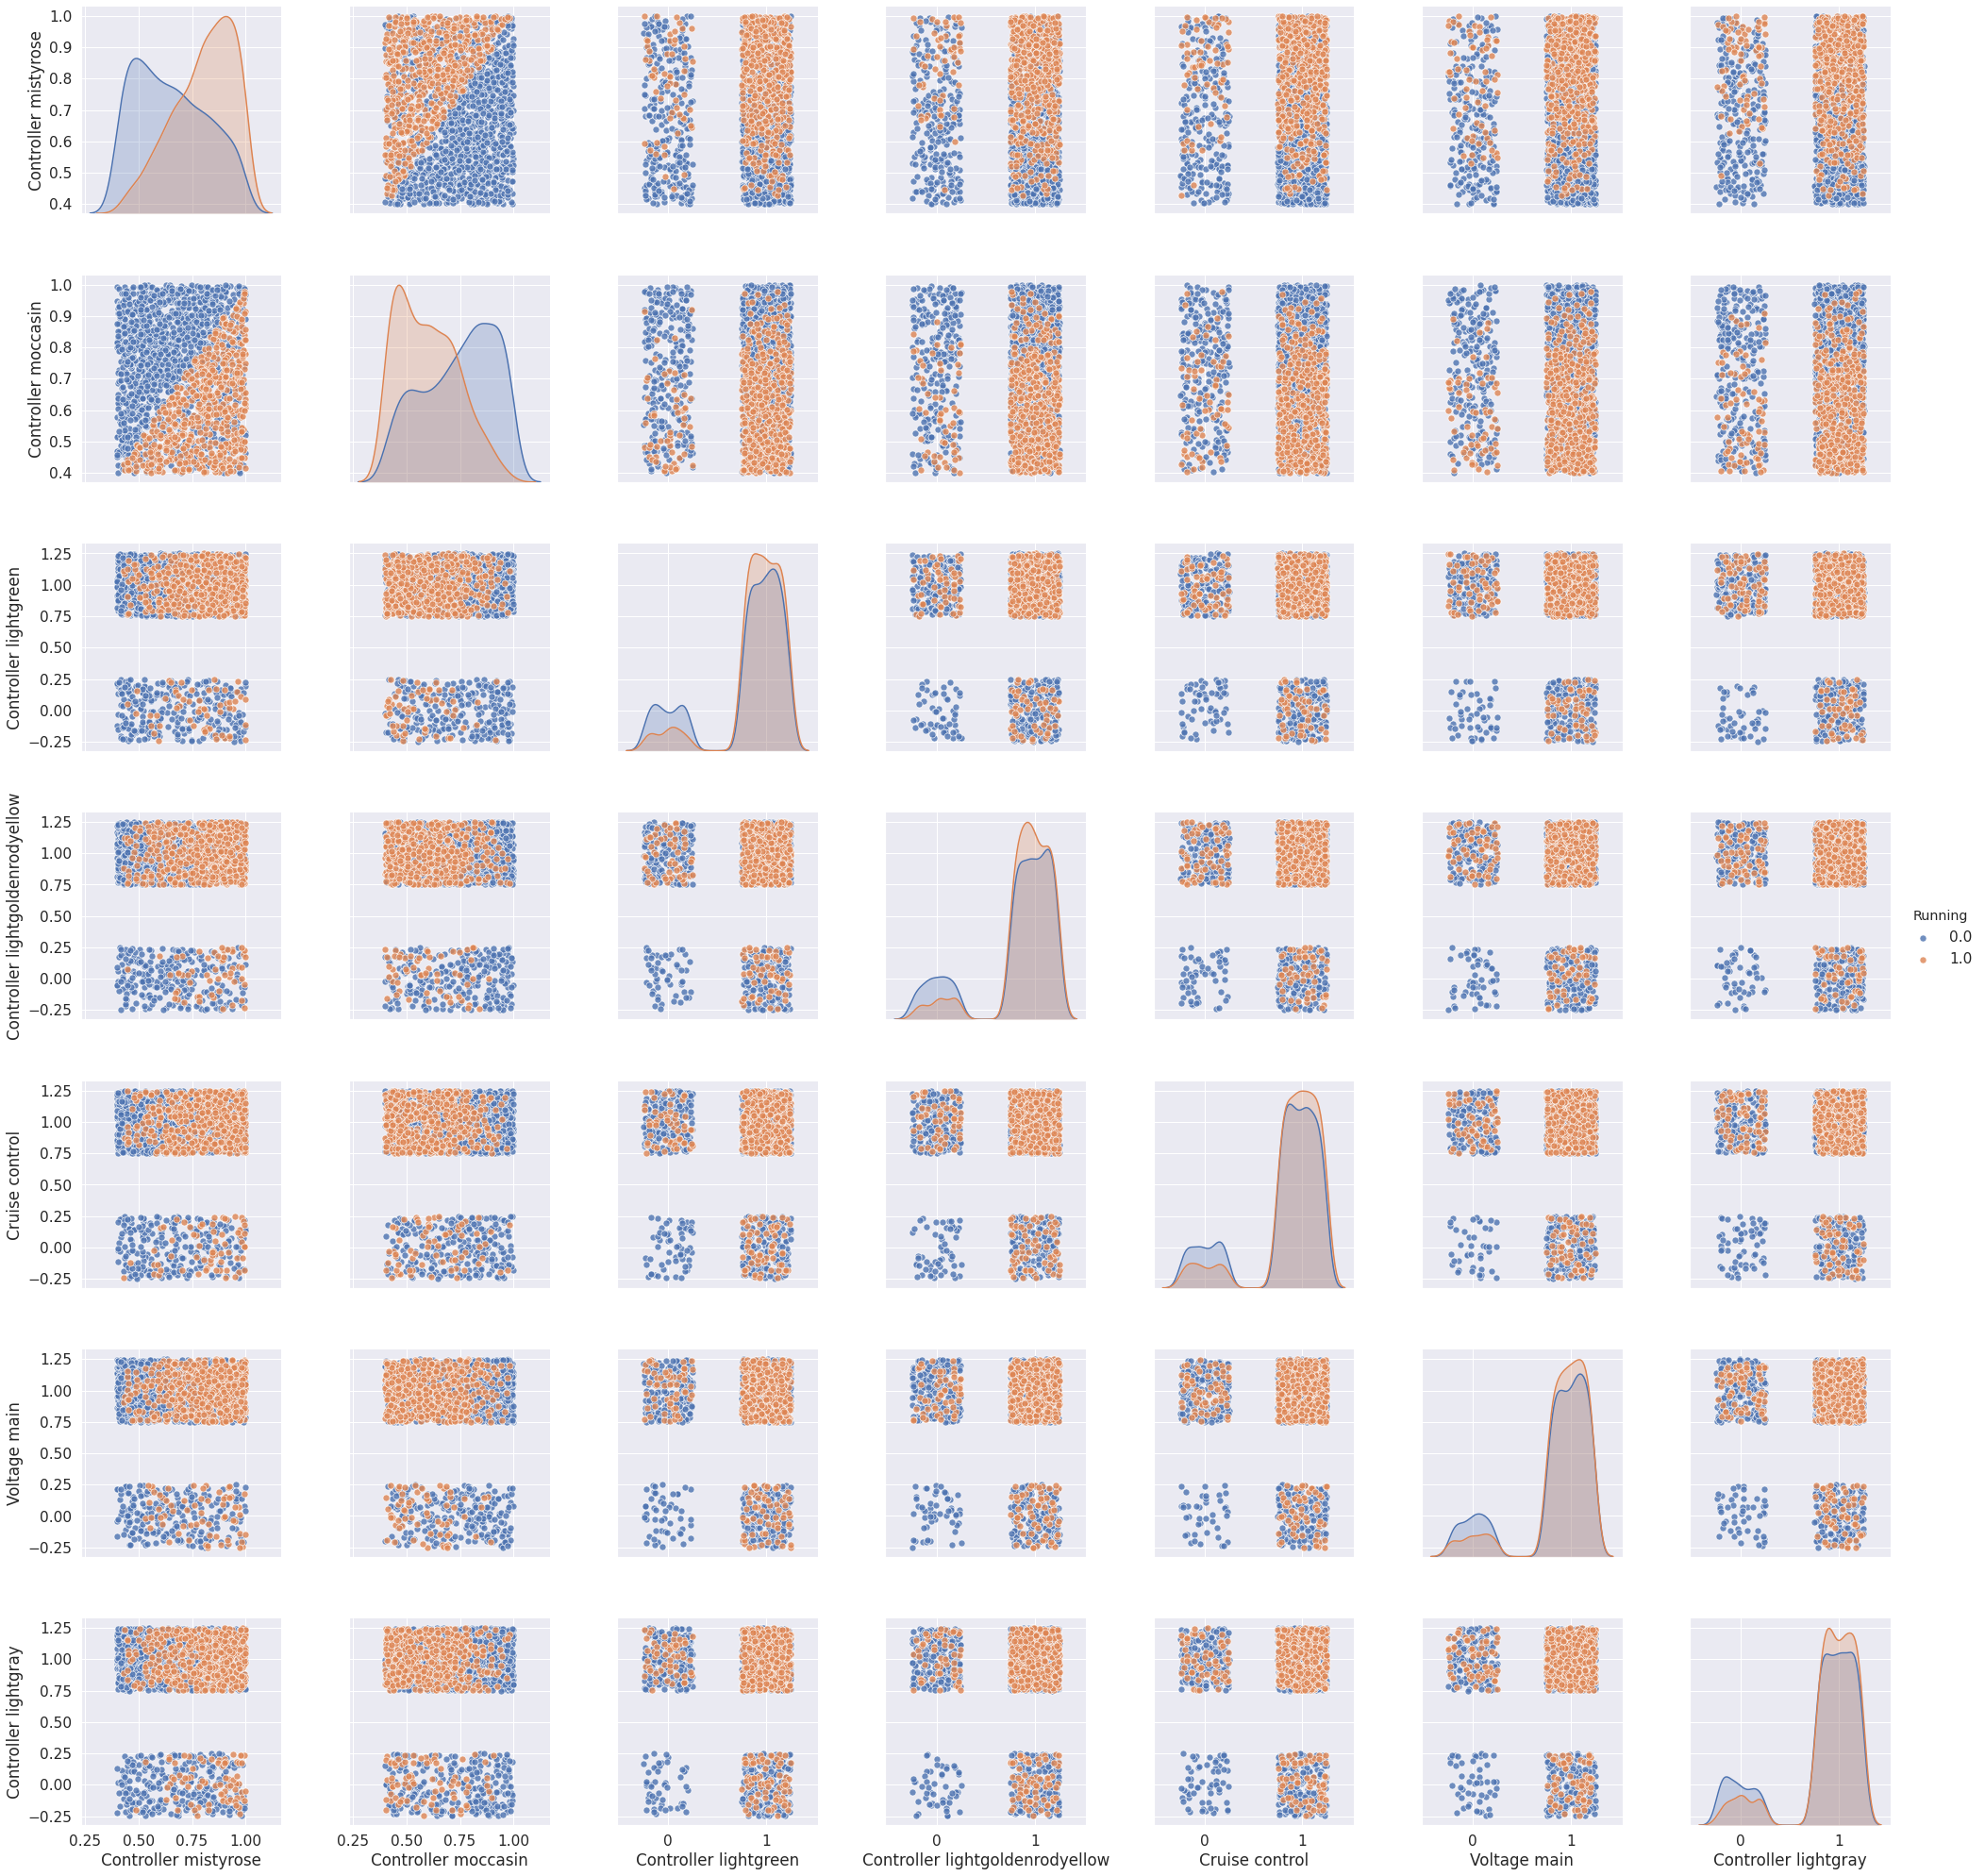

In [7]:
A=sn.pairplot(df_train_jitter,y_vars=S[0:7],x_vars=S[0:7],hue="Running",plot_kws={"s":50,'alpha':0.8},height=4)
plt.show()

We spot two things:

1) If **Controller moccasin > Controller mistyrose** the machine does not work.

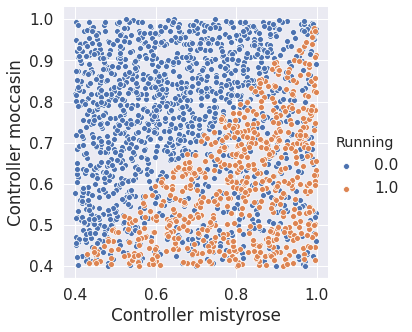

In [8]:
sn.pairplot(df_train,y_vars="Controller moccasin",x_vars="Controller mistyrose",hue="Running",plot_kws={"s": 35},height=5)
plt.show()

In [9]:
errors=0
for i in range(1000):
    if df_train["Controller mistyrose"][i]<=df_train["Controller moccasin"][i] and df_train["Running"][i]==1:
        errors+=1
print("When we test this assumtion we get", errors, "errors :)")

When we test this assumtion we get 0 errors :)


2) The second thing we notice is that in the graphic below there are never any orange points in the lower left squares, hence we assume that if at least **two of the plotted variables are 0** the machine does not run. 

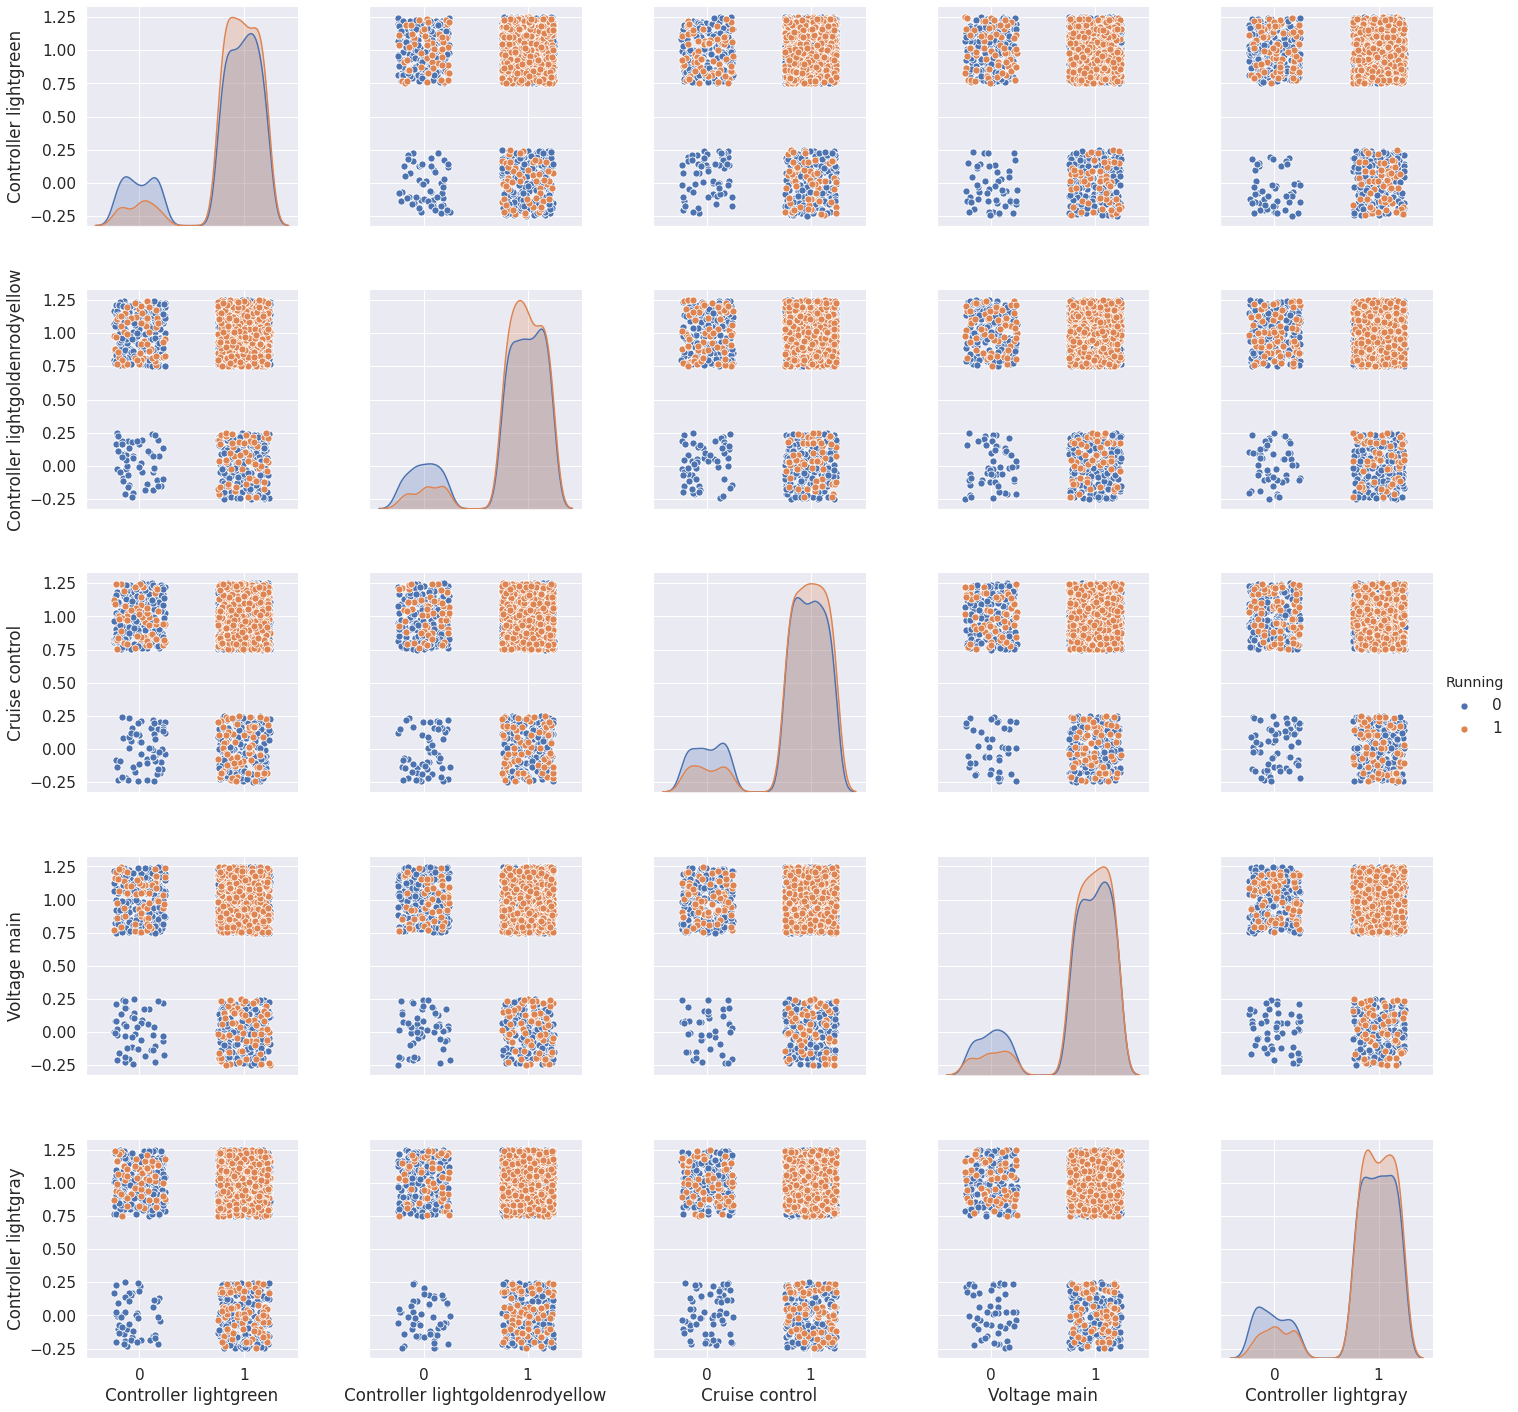

In [10]:
A=sn.pairplot(df_train_jitter,y_vars=S[2:7],x_vars=S[2:7],hue="Running",plot_kws={"s": 50,'alpha':1},height=4,hue_order=[0,1])
plt.show()

In [11]:
errors=0
for i in range(len(df_train)):
    if np.sum(df_train[S[2:7]],axis=1)[i]<=3:
        if df_train['Running'][i]:
            errors+=1
print("When we test this assumtion we get", errors, "errors :)")

When we test this assumtion we get 0 errors :)


# Filter out cases where the result has already been determined

Lets filter out the cases where the **Blue Switch On=0**, **Controller moccasin > Controller mistyrose** or **two of the above varibles are 0 at the same time** since we already know that the machine will not run in these cases

In [12]:
df_train0 = df_train[df_train["Blue Switch On"]!=0]
df_train1 = df_train0[df_train0["Controller moccasin"]<df_train0["Controller mistyrose"]]
df_train2 = df_train1[np.sum(df_train1[['Controller lightgreen', 'Controller lightgoldenrodyellow','Cruise control', 'Voltage main', 'Controller lightgray']],axis=1)>3]

Lets check how many times the machine runs or not runs in our filtered dataset

In [13]:
np.unique(df_train2["Running"],return_counts=True)

(array([0., 1.]), array([ 68, 623]))

Wow only 68 fails cases not accounted for!

Lets repeat the previous procedure:

# Looking for  patterns in the remaining data set

In [14]:
#S is the list of variables sorted by how highly (positively or negatively) corrolated they are with "Running" 
s = np.argsort(np.abs(np.array(df_train2.corr()['Running'])))[::-1]
S=columns[s]

#We delete "Running", "Blue Swich On" and the other binarie variables we already used
S = S.drop(['Running','Blue Switch On','Controller mistyrose', 'Controller moccasin', 'Controller lightgreen','Controller lightgoldenrodyellow', 'Cruise control'])


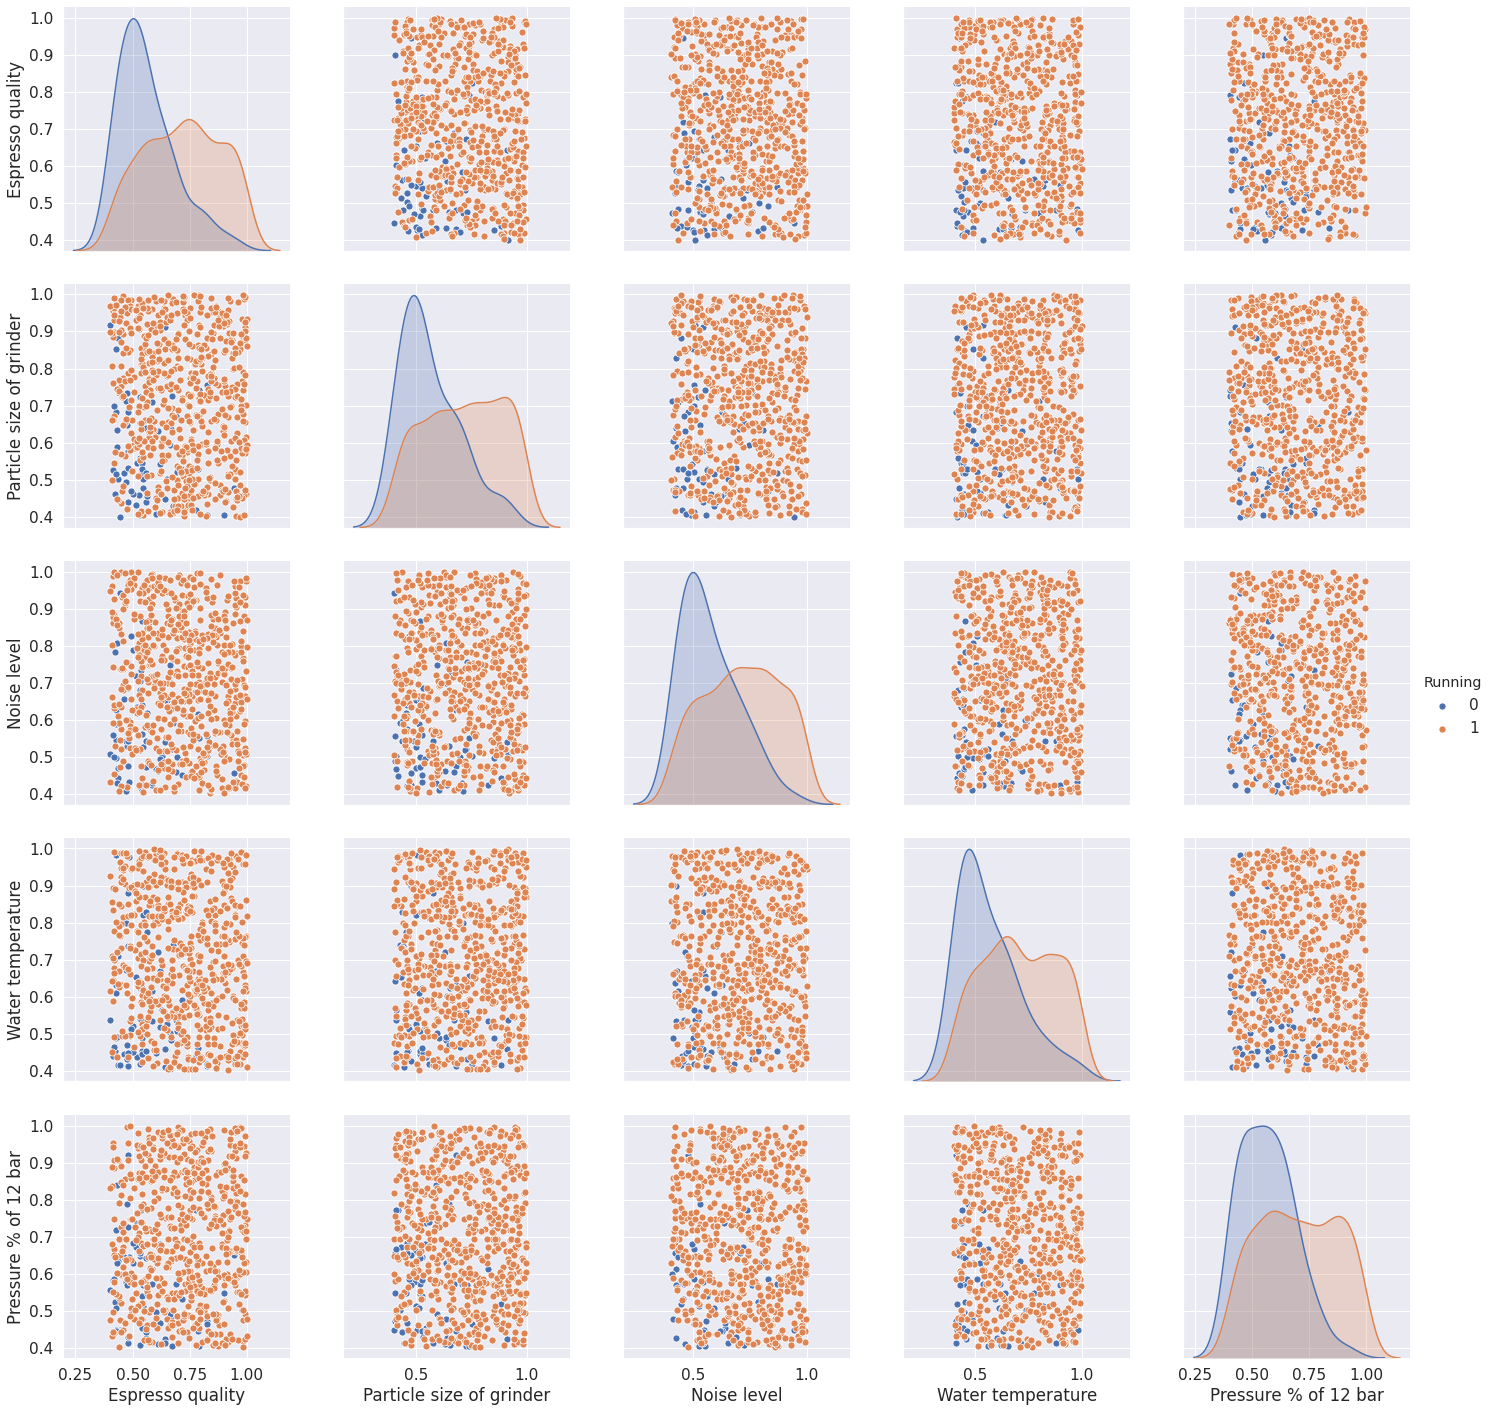

In [15]:
A=sn.pairplot(df_train2,y_vars=S[:5],x_vars=S[:5],hue="Running",plot_kws={"s": 50},height=4,hue_order=[0,1])
plt.show()

None of these are great classifiers but we suspect that the sum might be

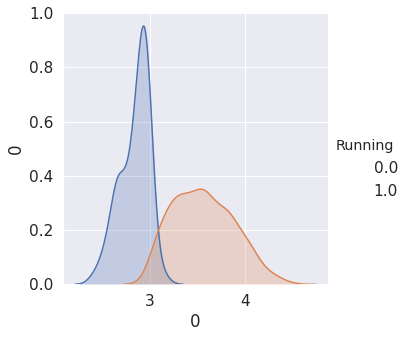

In [16]:
df_train2_sum=pd.concat([df_train2["Running"],np.sum(df_train2[['Espresso quality', 'Particle size of grinder', 'Noise level','Water temperature', 'Pressure % of 12 bar']],axis=1)],axis=1)

sn.pairplot(df_train2_sum,y_vars=0,x_vars=0,hue="Running",plot_kws={"s": 35},height=5)
plt.show()

3.0 looks like a good threshhold (it's better then it looks since the plot smoothes out the curves)

Lets look at how it holds up:

In [29]:
errors=0
for i in range(len(df_train2)):
    if np.array(np.sum(df_train2[['Espresso quality', 'Particle size of grinder', 'Noise level','Water temperature', 'Pressure % of 12 bar']],axis=1))[i]<3:
        if np.array(df_train2['Running'])[i]:
            #print("False Negative")
            errors+=1
    else:
        if not np.array(df_train2['Running'])[i]:
            #print("False Positive")
            errors+=1
print("When we test this assumtion we get", errors, "errors :)")

When we test this assumtion we get 2 errors :)


This looks great choosing 3 as a threshold gives a classifier that only makes 2 mistakes when classifing the remaining 691 samples

Let's formulate this classifier as a function:

In [18]:
def mycls(data,p=False):
    #determine if x is an outlier but maybee also useless since in the test set all outliers are also mapped to not Running which makes somewhat sense
    
    #check if "Blue Switch On"==1
    if data["Blue Switch On"]==0:
        if p:
            print("Blue Switch On")
        return 0
    
    #check if Controller moccasin > Controller mistyrose
    if data["Controller moccasin"] > data["Controller mistyrose"]:
        if p:
            print("Controller moccasin > Controller mistyrose")
        return 0

    #check  two of the varibles ['Controller lightgreen', 'Controller lightgoldenrodyellow',
    #'Cruise control', 'Voltage main', 'Controller lightgray'] are 0 at the same time
    if np.sum(data[['Controller lightgreen', 'Controller lightgoldenrodyellow','Cruise control', 'Voltage main', 'Controller lightgray']])<=3:
        if p:
            print("two varibles are 0 at the same time")
        return 0
    
    
    #check if sum(['Espresso quality', 'Particle size of grinder', 'Noise level',
    #              'Water temperature', 'Pressure % of 12 bar'])>3
    if np.sum(data[['Espresso quality', 'Particle size of grinder', 'Noise level', 'Water temperature', 'Pressure % of 12 bar']])<3:
        if p:
            print("np.sum(data[['Espresso quality', 'Particle size of grinder', 'Noise level','Water temperature', 'Pressure % of 12 bar']])<3")
        return 0

    return 1    

In [19]:
err=0
for x in df_train.T:
    if  df_train.T[x]['Running']!=mycls(df_train.T[x]):
        err+=1
print(err)

2


In [26]:
#These are the indices of the used variables
c=[0,1,70,71,72,73,74,80,81,82,83,84,98,99]

# Looking at Outliers:

In [21]:
def problems_dataset(data):
    to_drop= []
    for k in range(data.shape[0]):
        if data[k,:].std()>12:
            to_drop.append(k)   
    return to_drop# np.delete(data, to_drop, axis = 0)


In [22]:
problemtrain=problems_dataset(np.array(data_train_db))
problemtest=problems_dataset(np.array(data_test_db))
problemtrain,problemtest

([17, 372, 644, 881, 928], [168, 190, 216, 229, 253, 262, 461, 462, 475, 491])

In [23]:
qwertz=pd.DataFrame(np.array(data_train_db)[problemtrain],columns=columns)
qwertz["Running"]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Running, dtype: float64

This could let us assume that the machine does not run for outliers, especially since the classifier "mycls" gives a false positve on the sample:

In [24]:
for x in qwertz.T:
    print(mycls(qwertz.T[x]),end=", ")

0, 0, 0, 1, 0, 

But since "mycls" classifies all outliers in the testset as not running anyhow, we will not have to code that assumtion into the classifier:

In [25]:
for x in problemtest:
    print(mycls(data_test_db.T[x]),end=", ")

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 